# Classification via Kernel Density Estimation

The key to classification with generative models is to start from class prior distributions
\begin{align*}
\text{Pr}(Y = k) = \pi_k
\end{align*}
for $k = 1, \ldots, K$. We then also need the class-conditional distributions
\begin{align*}
p_k(x) = \text{Pr}(X = x | Y = k)
\end{align*}
to be able to use the Bayes' rule for given  covariate $x$
\begin{align*}
\text{Pr}(Y = k | X = x) = \frac{\text{Pr}(X=x | Y = k)\pi_k}{\sum_{l=1}^K \text{Pr}(X=x | Y = l)\pi_l}.
\end{align*}
Methods like linear discriminant analysis (LDA), quadratic discriminant analysis (QDA), naive Bayes (NB) all approximate the conditional density $\text{Pr}(X = x | Y = k)$ with specific assumptions.

In this notebook, I will generalise these methods and get a general purpose classifier which estimates the densities directly from data, hence much more flexible.

Specifically, I will build my own estimates for $\text{Pr}(X = x | Y = k)$. However, I will refrain from using particular parametric forms, instead I will use *kernel density estimation* (KDE). These are methods to build estimates of distributions given some data from them. In this context, I will need to build KDEs for each class conditioned on $Y = k$. Once I've got these densities, I will need to then evaluate the corresponding decision rules. I will assume throughout empirical priors, i.e., just the ratio of data points as priors. I will focus on $K = 2$ always.

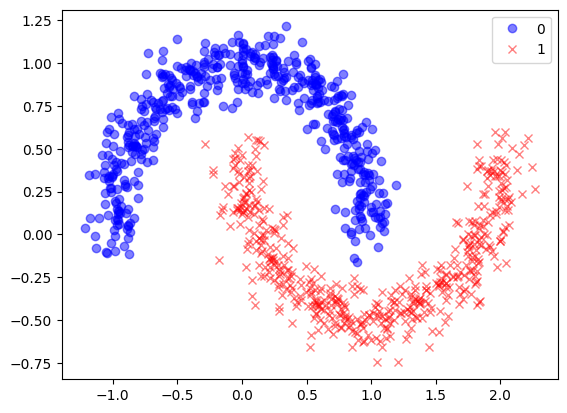

In [1]:
# LOAD DATA
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("data/moons.csv", delimiter=",", skiprows=1)

# Separate the data into X and y
X = data[:, :2]
y = data[:, 2]

plt.plot(X[y==0, 0], X[y==0, 1], 'ob', alpha=0.5)
plt.plot(X[y==1, 0], X[y==1, 1], 'xr', alpha=0.5)
plt.legend(['0', '1'])
plt.show()

In [2]:
# Import all modules used in the notebook
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KernelDensity
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, RocCurveDisplay

In [3]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

The two classes follow semi-circular patterns in $X1$-$X2$ space.
- Linear Discriminant Analysis (LDA) and Quadratic Discriminant Analysis (QDA) both assume that the covariate variables within each class follow a multivariate (in this case 2 variable) normal distribution. We can easily see that this is not the case. Furthermore, the ends of the two semi-circles overlap but LDA and QDA will produce linear and quadratic decision boundaries in $X1$-$X2$ space, respectively. Both LDA and QDA will therefore struggle with this dataset.
- Naive Bayes (NB) assumes that, conditional on $Y=k$, the covariate variables are independent. This is clearly not the case so NB will therefore struggle with this dataset.

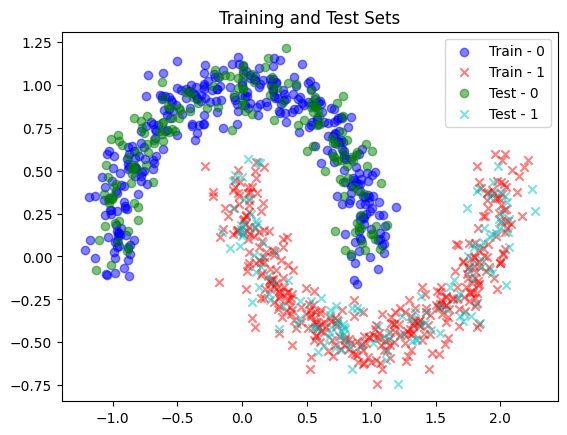

In [4]:
# Plot the training set
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], marker='o', color = 'b', label='Train - 0', alpha=0.5)
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], marker='x', color = 'r', label='Train - 1', alpha=0.5)

# Plot the test set
plt.scatter(X_test[y_test == 0, 0], X_test[y_test == 0, 1], marker='o', color = 'g', label='Test - 0', alpha=0.5)
plt.scatter(X_test[y_test == 1, 0], X_test[y_test == 1, 1], marker='x', color = 'c', label='Test - 1', alpha=0.5)

# Add legend and show the plot
plt.legend()
plt.title('Training and Test Sets')
plt.show()

In the plot above, there is no visible pattern in the points that have been chosen as test data.

I will: fit LDA on the training data; provide the confusion matrix and misclassification rate on the test data; plot the decision boundary against the training data.

In [5]:
def plot_confusion_matrix(X_train, X_test, y_train, y_test, model):
    '''
    This function plots the confusion matrix.
    Params:
        X_train, X_test, y_train, y_test: Training and test data
        model: sklearn's LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis or GaussianNB
    '''
    # Fit on the training data
    model_fit = model.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = model_fit.predict(X_test)
    
    # Plot the confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=['0', '1'])
    disp.plot()
    plt.show()

In [6]:
def misclassification_rate(X_train, X_test, y_train, y_test, model):
    '''
    This function returns the misclassification rate.
    Params:
        X_train, X_test, y_train, y_test: Training and test data
        model: sklearn's LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis or GaussianNB
    '''
    # Fit on the training data
    model_fit = model.fit(X_train, y_train)
    
    # Predict on the test data
    y_pred = model_fit.predict(X_test)
    
    # Return the misclassification rate
    misclassification_rate = 1 - accuracy_score(y_test, y_pred)
    return misclassification_rate

In [7]:
def plot_decision_boundary(X_train, X_test, y_train, y_test, model):
    '''
    This function plots the decision boundary.
    Params:
        X_train, X_test, y_train, y_test: Training and test data
        model: sklearn's LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis or GaussianNB
    '''
    # Fit on the training data
    model_fit = model.fit(X_train, y_train)
    
    # Plot the decision boundary
    x1 = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 100)
    x2 = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 100)
    X1, X2 = np.meshgrid(x1, x2)
    y_pred = model_fit.predict(np.c_[X1.ravel(), X2.ravel()])
    y_pred = y_pred.reshape(X1.shape)
    plt.contourf(X1, X2, y_pred, cmap='bwr', alpha=0.5)
    plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
                marker='o', color = 'b', label='Train - 0', alpha=0.5)
    plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
                marker='x', color = 'r', label='Train - 1', alpha=0.5)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('Decision Boundary on Training Data')
    plt.legend()
    plt.show()

In [8]:
# Initiate sklearn's LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis()

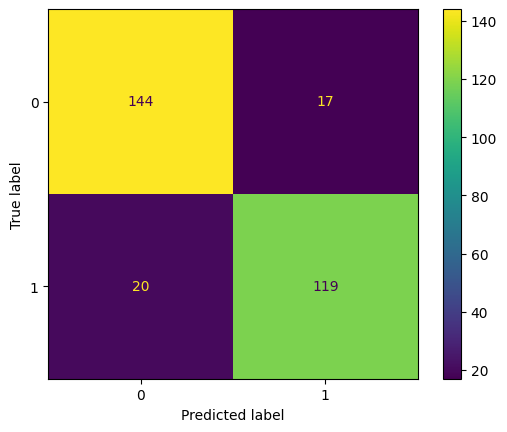

In [9]:
plot_confusion_matrix(X_train, X_test, y_train, y_test, lda)

In [10]:
print("Misclassification Rate:", misclassification_rate(X_train, X_test, y_train, y_test, lda))

Misclassification Rate: 0.1233333333333333


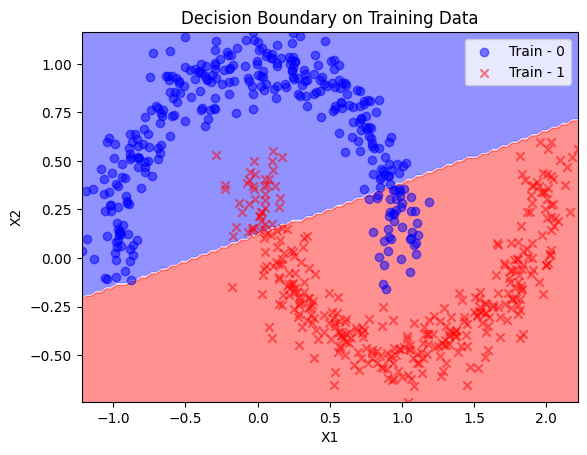

In [11]:
plot_decision_boundary(X_train, X_test, y_train, y_test, lda)

The performance of LDA on the "two moons" dataset isn't too bad. However, from the above plot of the decision boundary, it is clear that LDA does not capture all the complexities of the dataset.

I will: fit QDA on the training data; provide the confusion matrix and misclassification rate on the test data; plot the decision boundary against the training data.

In [12]:
# Initiate sklearn's QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()

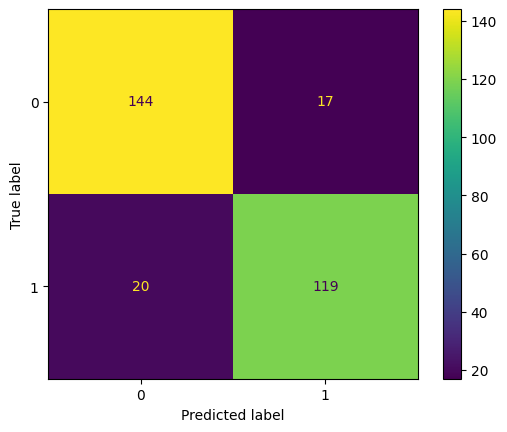

In [13]:
plot_confusion_matrix(X_train, X_test, y_train, y_test, qda)

In [14]:
print("Misclassification Rate:", misclassification_rate(X_train, X_test, y_train, y_test, qda))

Misclassification Rate: 0.1233333333333333


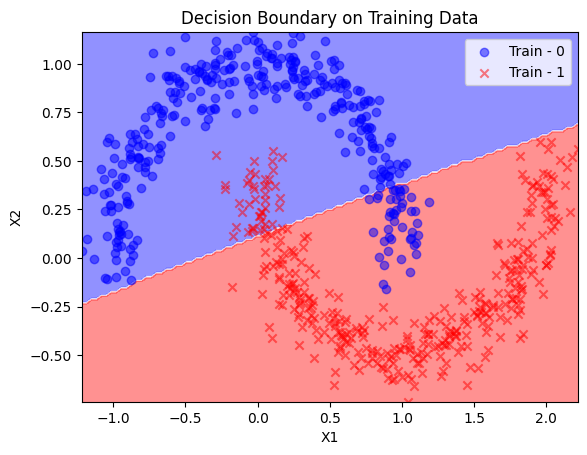

In [15]:
plot_decision_boundary(X_train, X_test, y_train, y_test, qda)

I will: fit NB on the training data; provide the confusion matrix and misclassification rate on the test data; plot the decision boundary against the training data; plot the ROC curve.

In [16]:
# Initiate sklearn's GaussianNB
nb = GaussianNB()

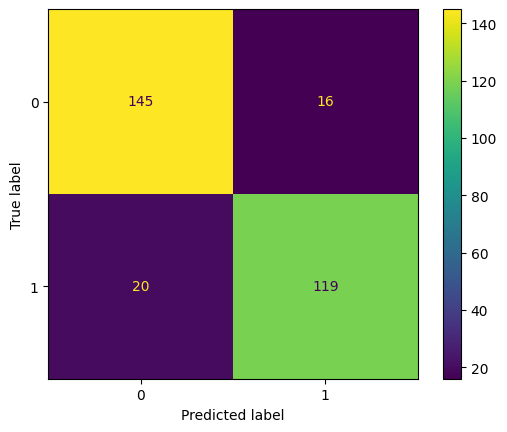

In [17]:
plot_confusion_matrix(X_train, X_test, y_train, y_test, nb)

In [18]:
print("Misclassification Rate:", misclassification_rate(X_train, X_test, y_train, y_test, nb))

Misclassification Rate: 0.12


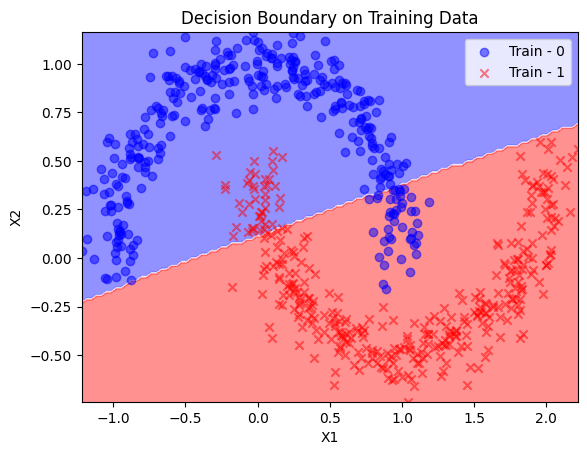

In [19]:
plot_decision_boundary(X_train, X_test, y_train, y_test, nb)

The performance of QDA and NB on the "two moons" dataset aren't too bad. However, from the above plot of the decision boundary, it is clear that neither captures all the complexities of the dataset. It is also interesting to note how similar the QDA and NB models are to the LDA model on this dataset.

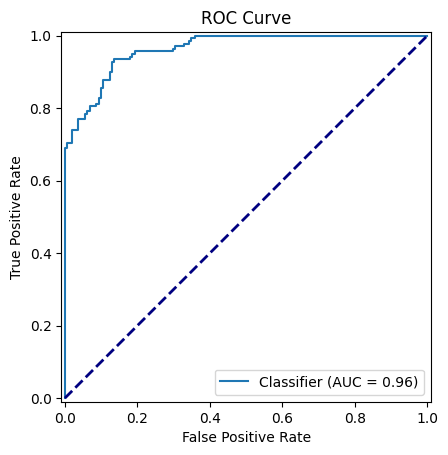

In [20]:
# Fit NB on the training data
nb_fit = nb.fit(X_train, y_train)

# Access the probabilities using the predict_proba method on the test data
# NOTE:
#    [:, 1] gives the probabilities for class 1 (or 'success')
#    and this is required to plot the ROC curve.
y_pred_prob = nb_fit.predict_proba(X_test)[:, 1]

roc_curve = RocCurveDisplay.from_predictions(y_test, y_pred_prob)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Add labels and title for clarity
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")

# Show the plot
plt.show()

I will: fit KDE on the training data; provide the confusion matrix and misclassification rate on the test data; plot the decision boundary against the training data.

Kernel Density Estimation (KDE) can be used for classification by estimating the probability density function (PDF) for each class based on the training data and then classifying a new point $x$ by taking the class with the highest log-likelihood given the estimated PDF for each class.

In [21]:
def plot_kde_confusion_matrix(X_train, X_test, y_train, y_test, bandwidth):
    '''
    This function plots the confusion matrix for KDE.
    Params:
        X_train, X_test, y_train, y_test: Training and test data
        bandwidth: The bandwidth of the kernel.
    '''
    # Initiate sklearn's KernelDensity for each class
    kde_class_0 = KernelDensity(bandwidth=bandwidth)
    kde_class_1 = KernelDensity(bandwidth=bandwidth)
    
    # Fit on the training data for each class
    X_train_class_0 = X_train[y_train == 0]
    X_train_class_1 = X_train[y_train == 1]
    kde_class_0_fit = kde_class_0.fit(X_train_class_0)
    kde_class_1_fit = kde_class_1.fit(X_train_class_1)
    
    # Access the estimated log-likelihood values using the score_samples method on the test data
    log_likelihood_class_0 = kde_class_0_fit.score_samples(X_test)
    log_likelihood_class_1 = kde_class_1_fit.score_samples(X_test)
    
    # Assign the class with the highest estimated log-likelihood
    y_pred = (log_likelihood_class_1 > log_likelihood_class_0).astype(int)
    
    # Plot the confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=['0', '1'])
    disp.plot()
    plt.show()

In [22]:
def kde_misclassification_rate(X_train, X_test, y_train, y_test, bandwidth):
    '''
    This function returns the misclassification rate for KDE.
    Params:
        X_train, X_test, y_train, y_test: Training and test data
        bandwidth: The bandwidth of the kernel.
    '''
    # Initiate sklearn's KernelDensity for each class
    kde_class_0 = KernelDensity(bandwidth=bandwidth)
    kde_class_1 = KernelDensity(bandwidth=bandwidth)
    
    # Fit on the training data for each class
    X_train_class_0 = X_train[y_train == 0]
    X_train_class_1 = X_train[y_train == 1]
    kde_class_0_fit = kde_class_0.fit(X_train_class_0)
    kde_class_1_fit = kde_class_1.fit(X_train_class_1)
    
    # Access the estimated log-likelihood values using the score_samples method on the test data
    log_likelihood_class_0 = kde_class_0_fit.score_samples(X_test)
    log_likelihood_class_1 = kde_class_1_fit.score_samples(X_test)
    
    # Assign the class with the highest estimated log-likelihood
    y_pred = (log_likelihood_class_1 > log_likelihood_class_0).astype(int)

    # Return the misclassification rate
    misclassification_rate = 1 - accuracy_score(y_test, y_pred)
    return misclassification_rate

In [23]:
def plot_kde_decision_boundary(X_train, X_test, y_train, y_test, bandwidth):
    '''
    This function plots the decision boundary for KDE.
    Params:
        X_train, X_test, y_train, y_test: Training and test data
        bandwidth: The bandwidth of the kernel.
    '''
    # Initiate sklearn's KernelDensity for each class
    kde_class_0 = KernelDensity(bandwidth=bandwidth)
    kde_class_1 = KernelDensity(bandwidth=bandwidth)
    
    # Fit on the training data for each class
    X_train_class_0 = X_train[y_train == 0]
    X_train_class_1 = X_train[y_train == 1]
    kde_class_0_fit = kde_class_0.fit(X_train_class_0)
    kde_class_1_fit = kde_class_1.fit(X_train_class_1)
    
    # Plot the decision boundary
    x1 = np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 100)
    x2 = np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 100)
    X1, X2 = np.meshgrid(x1, x2)
    log_likelihood_class_0 = kde_class_0_fit.score_samples(np.c_[X1.ravel(), X2.ravel()])
    log_likelihood_class_1 = kde_class_1_fit.score_samples(np.c_[X1.ravel(), X2.ravel()])
    y_pred = (log_likelihood_class_1 > log_likelihood_class_0).astype(int)
    y_pred = y_pred.reshape(X1.shape)
    plt.contourf(X1, X2, y_pred, cmap='bwr', alpha=0.5)
    plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1],
                marker='o', color='b', label='Train - 0', alpha=0.5)
    plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1],
                marker='x', color='r', label='Train - 1', alpha=0.5)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.title('KDE Decision Boundary on Training Data')
    plt.legend()
    plt.show()

I will specify `bandwidth='scott'` to apply Scott’s estimation method.

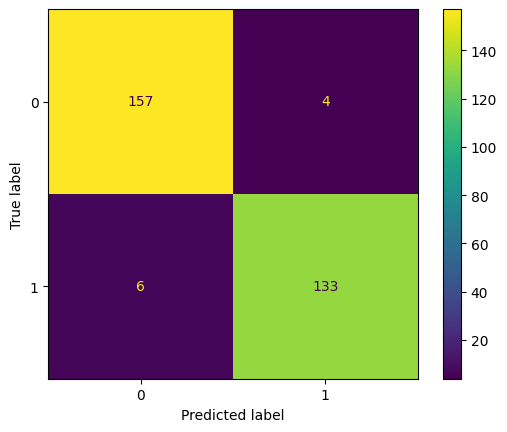

In [24]:
plot_kde_confusion_matrix(X_train, X_test, y_train, y_test, bandwidth='scott')

In [25]:
print("Misclassification Rate:", kde_misclassification_rate(X_train, X_test, y_train, y_test, bandwidth='scott'))

Misclassification Rate: 0.033333333333333326


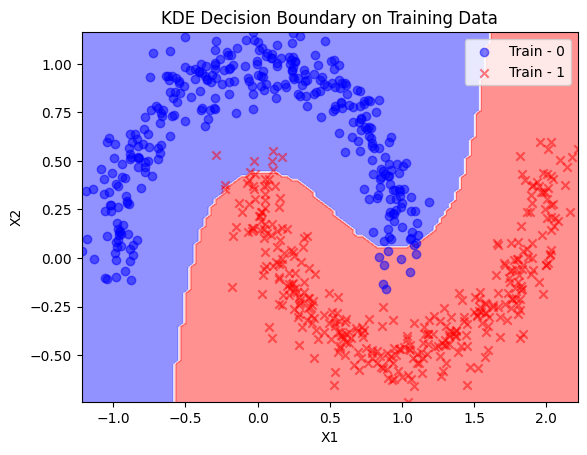

In [26]:
plot_kde_decision_boundary(X_train, X_test, y_train, y_test, bandwidth='scott')

The use of KDEs (along with Scott’s estimation method for the `bandwidth` parameter) is drastically better than the above standard classifiers. It also seems to capture many more of the complexities of the dataset.

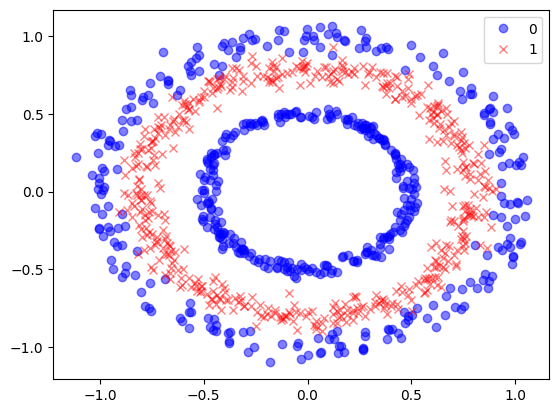

In [27]:
# LOAD DATA
import numpy as np
import matplotlib.pyplot as plt

data = np.loadtxt("data/circles.csv", delimiter=",", skiprows=1)

# Separate the data into X and y

X = data[:, :2]
y = data[:, 2]

plt.plot(X[y==0, 0], X[y==0, 1], 'ob', alpha=0.5)
plt.plot(X[y==1, 0], X[y==1, 1], 'xr', alpha=0.5)
plt.legend(['0', '1'])
plt.show()

In [28]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

I will: fit LDA on the training data; provide the confusion matrix and misclassification rate on the test data; plot the decision boundary against the training data.

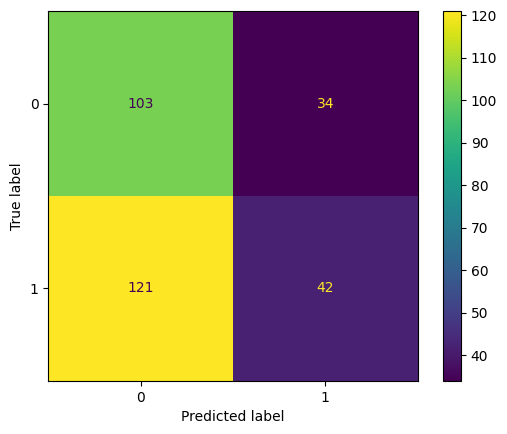

In [29]:
plot_confusion_matrix(X_train, X_test, y_train, y_test, lda)

In [30]:
print("Misclassification Rate:", misclassification_rate(X_train, X_test, y_train, y_test, lda))

Misclassification Rate: 0.5166666666666666


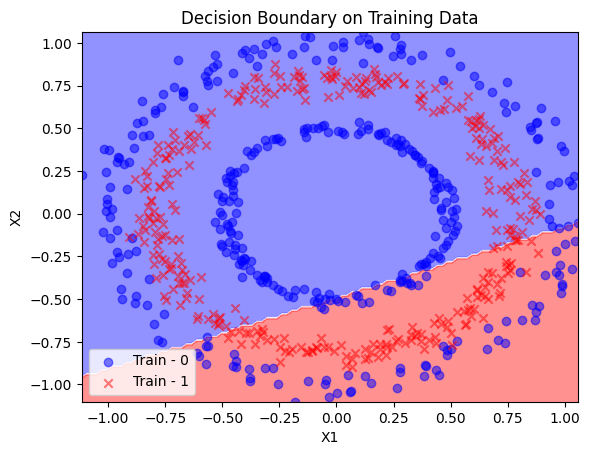

In [31]:
plot_decision_boundary(X_train, X_test, y_train, y_test, lda)

I will: fit QDA on the training data; provide the confusion matrix and misclassification rate on the test data; plot the decision boundary against the training data.

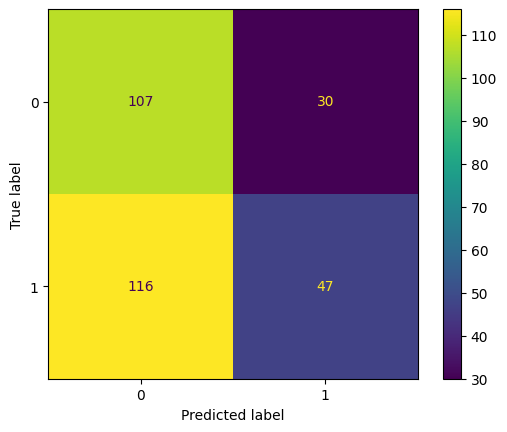

In [32]:
plot_confusion_matrix(X_train, X_test, y_train, y_test, qda)

In [33]:
print("Misclassification Rate:", misclassification_rate(X_train, X_test, y_train, y_test, qda))

Misclassification Rate: 0.4866666666666667


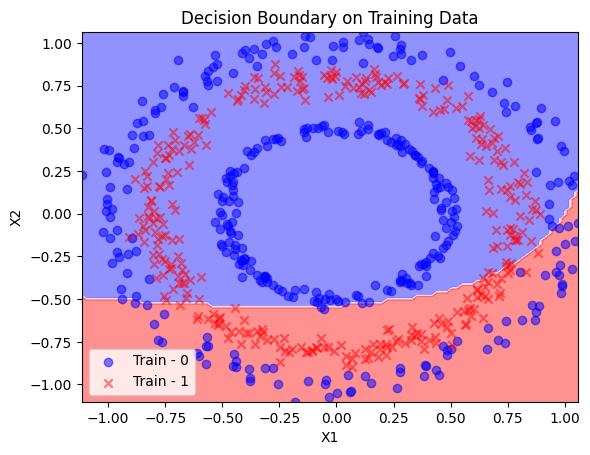

In [34]:
plot_decision_boundary(X_train, X_test, y_train, y_test, qda)

I will: fit NB on the training data; provide the confusion matrix and misclassification rate on the test data; plot the decision boundary against the training data.

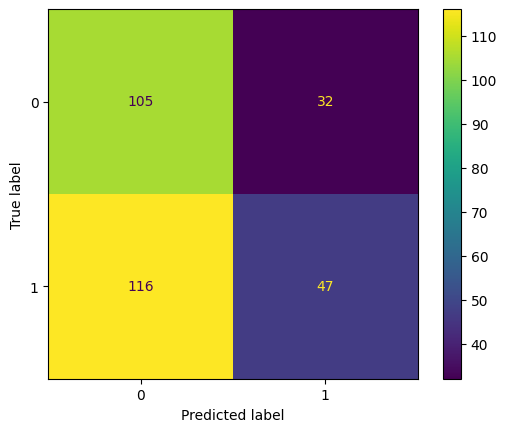

In [35]:
plot_confusion_matrix(X_train, X_test, y_train, y_test, nb)

In [36]:
print("Misclassification Rate:", misclassification_rate(X_train, X_test, y_train, y_test, nb))

Misclassification Rate: 0.4933333333333333


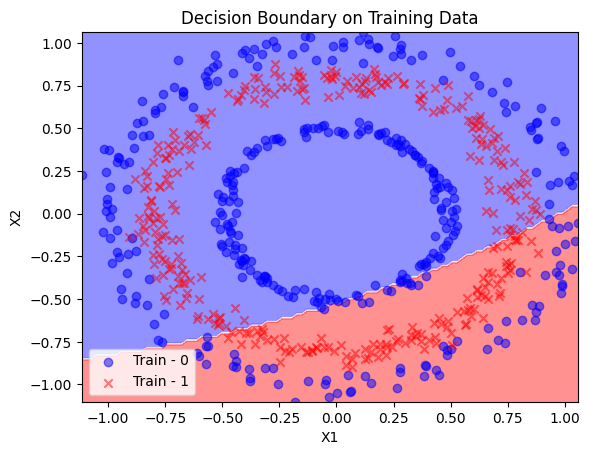

In [37]:
plot_decision_boundary(X_train, X_test, y_train, y_test, nb)

All three of the above standard classifiers perform very badly on this dataset. Since this is a binary classification problem and the misclassification rate for all three is close to $0.5$ on test data, they perform equivalently to random guessing. Furthermore, the plots of the decision boundaries show that none capture the complexities of the dataset.

The `KernelDensity` class has a `bandwidth` parameter. This is a hyperparameter that can be tuned. I will identify the best parameter in terms of the misclassification rate.

The best parameter in terms of the misclassification rate will depend on the train test split. Usually I would simulate many different train test splits, however the notebook is structured such that we split the data at the beginning. I am therefore interpreting the question as 'Identify the best parameter in terms of the misclassification rate for my specific train test split.'

Step 1: Visualise the optimisation problem at hand.

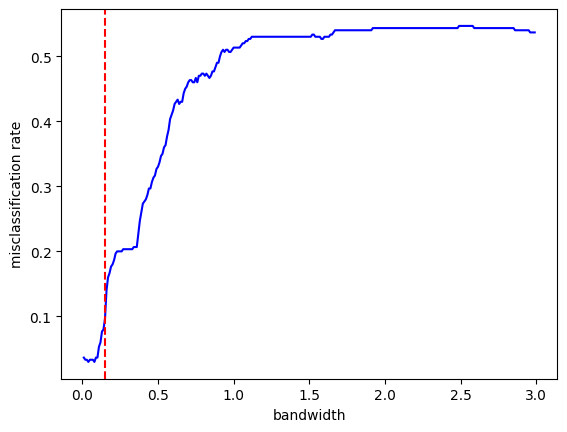

In [38]:
# Plot the misclassification rates for a large range of bandwidths
bandwidths = np.arange(0.01, 3, 0.01)
kde_misclassification_rates = np.empty_like(bandwidths)

for i, bandwidth in enumerate(bandwidths):
    kde_misclassification_rates[i] = kde_misclassification_rate(X_train, X_test, y_train, y_test, bandwidth=bandwidth)

plt.plot(bandwidths, kde_misclassification_rates, color = 'b')

# Add a vertical line at bandwidth=0.15
plt.axvline(x=0.15, color='r', linestyle='--')

plt.xlabel('bandwidth')
plt.ylabel('misclassification rate')
plt.show()

The above plot suggests that the value of `bandwidth` that minimises the misclassification rate lies somewhere in the range $(0, 0.15)$.

Step 2: Taking the hint that I may have to search numbers close to zero, perform a grid search between $0.0001$ and $0.15$.

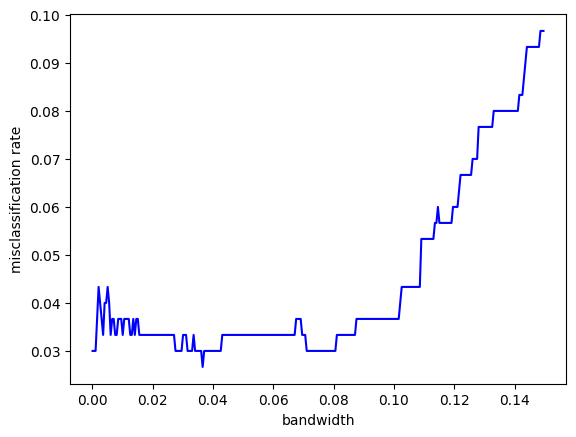

In [39]:
# I will start the grid search at 0.0001 and use intervals of 0.0005
bandwidths = np.arange(0.0001, 0.15, 0.0005)
kde_misclassification_rates = np.empty_like(bandwidths)

for i, bandwidth in enumerate(bandwidths):
    kde_misclassification_rates[i] = kde_misclassification_rate(X_train, X_test, y_train, y_test, bandwidth=bandwidth)

plt.plot(bandwidths, kde_misclassification_rates, color = 'b')
plt.xlabel('bandwidth')
plt.ylabel('misclassification rate')
plt.show()

In [40]:
# Print the bandwidth(s) that minimise(s) the misclassification rate
bandwidths[np.where(kde_misclassification_rates == np.min(kde_misclassification_rates))]

array([0.0366])

For my train test split, there happens to be only one value of `bandwidth` that minimises the misclassification rate.

In [41]:
best_bandwidth = bandwidths[np.where(kde_misclassification_rates == np.min(kde_misclassification_rates))][0]

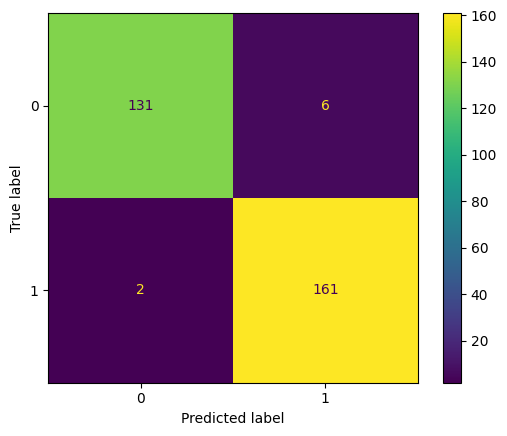

In [42]:
plot_kde_confusion_matrix(X_train, X_test, y_train, y_test, bandwidth=best_bandwidth)

In [43]:
print("Misclassification Rate:", kde_misclassification_rate(X_train, X_test, y_train, y_test, bandwidth=best_bandwidth))

Misclassification Rate: 0.026666666666666616


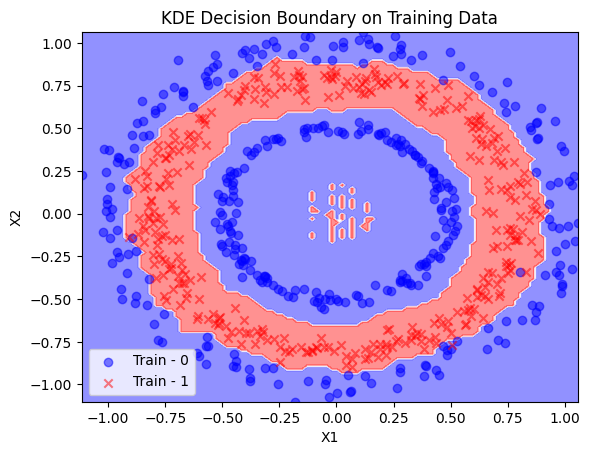

In [44]:
plot_kde_decision_boundary(X_train, X_test, y_train, y_test, bandwidth=best_bandwidth)

The use of KDEs (along with the best `bandwidth` parameter) is drastically better than the above standard classifiers. It is also interesting to note that my classifier is predicting Class 1 at points in the neighbourhood of $(0, 0)$.